In [ ]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [ ]:
!pip install --quiet git+https://github.com/theislab/scgen.git

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### Import the metric -- scib

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

In [ ]:
!pip install --quiet louvain
import louvain

## Import the data

In [6]:
import anndata
adata = anndata.read_h5ad("../bct_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 9288 × 1222
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'study', 'cell.class', 'library_size', 'detected_genes', 'batch', 'cell_type'
    var: 'gene.symbols', 'gene.counts'

In [29]:
# # Renaming the 'celltype' column to 'cell_type'
# adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)

# # Replacing the 'batch' column with the values from 'BATCH'
# # Assuming 'BATCH' exists in the DataFrame
# adata.obs['batch'] = adata.obs['BATCH']

In [32]:
# import pandas as pd

# # Create a new DataFrame for the `var` metadata
# new_var = pd.DataFrame(index=adata.var_names)

# # Populate the DataFrame with some example metadata
# # For example, let's just create a column named 'gene_name' with the same names as index
# new_var['gene_name'] = adata.var_names

# # Assign this DataFrame to adata.var
# adata.var = new_var

# # Verify the changes
# print(adata.var.head())

                 gene_name
index                     
ZNF692              ZNF692
ZNF672_p          ZNF672_p
SH3BP5L            SH3BP5L
LOC102117280  LOC102117280
LYPD8                LYPD8


In [8]:
# adata.write_h5ad('../bct_raw.h5ad')

In [7]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [9]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [39]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 264/264: 100%|█| 264/264 [25:32<00:00,  4.78s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=264` reached.


Epoch 264/264: 100%|█| 264/264 [25:32<00:00,  5.81s/it, v_num=1, train_loss_step


In [40]:
# Assuming 'vae' is your trained model
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [11]:
# Setup anndata with the same parameters used for training
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [12]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

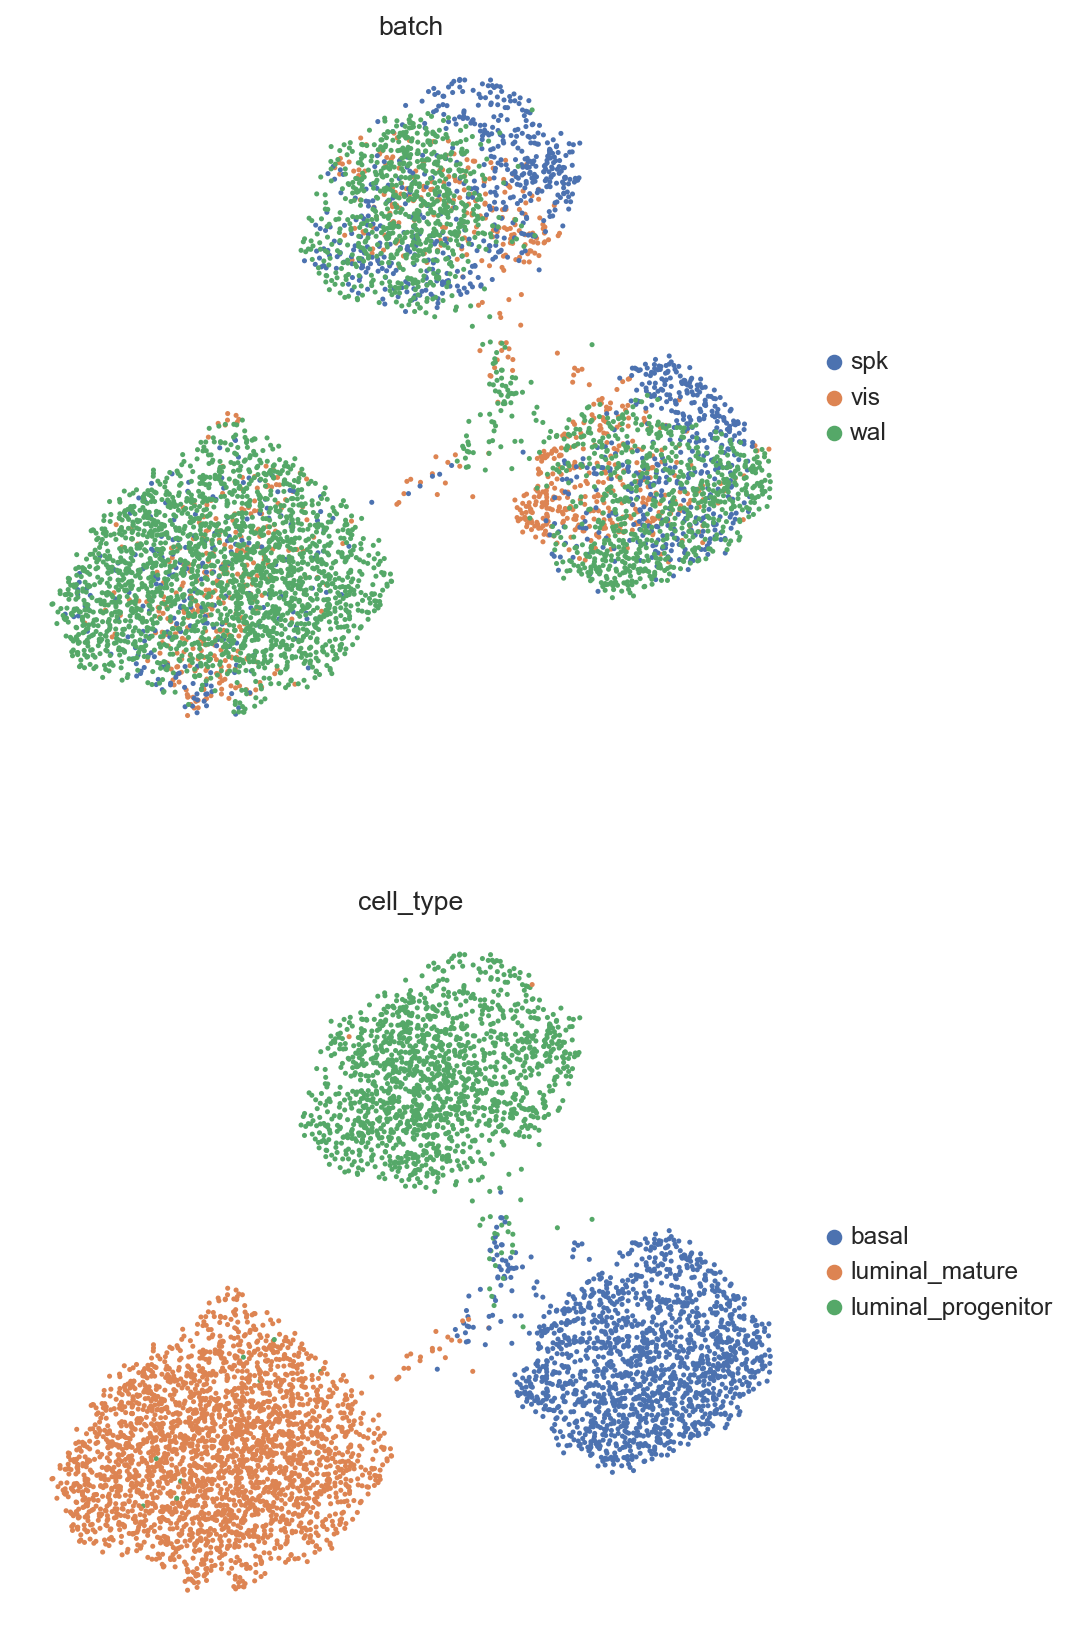

In [13]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [14]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

In [15]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|█| 20/20 [00:10<00:00,  1.84it/s, v_num=1, train_loss_step=1.1

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [00:10<00:00,  1.82it/s, v_num=1, train_loss_step=1.1


In [16]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [17]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [18]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

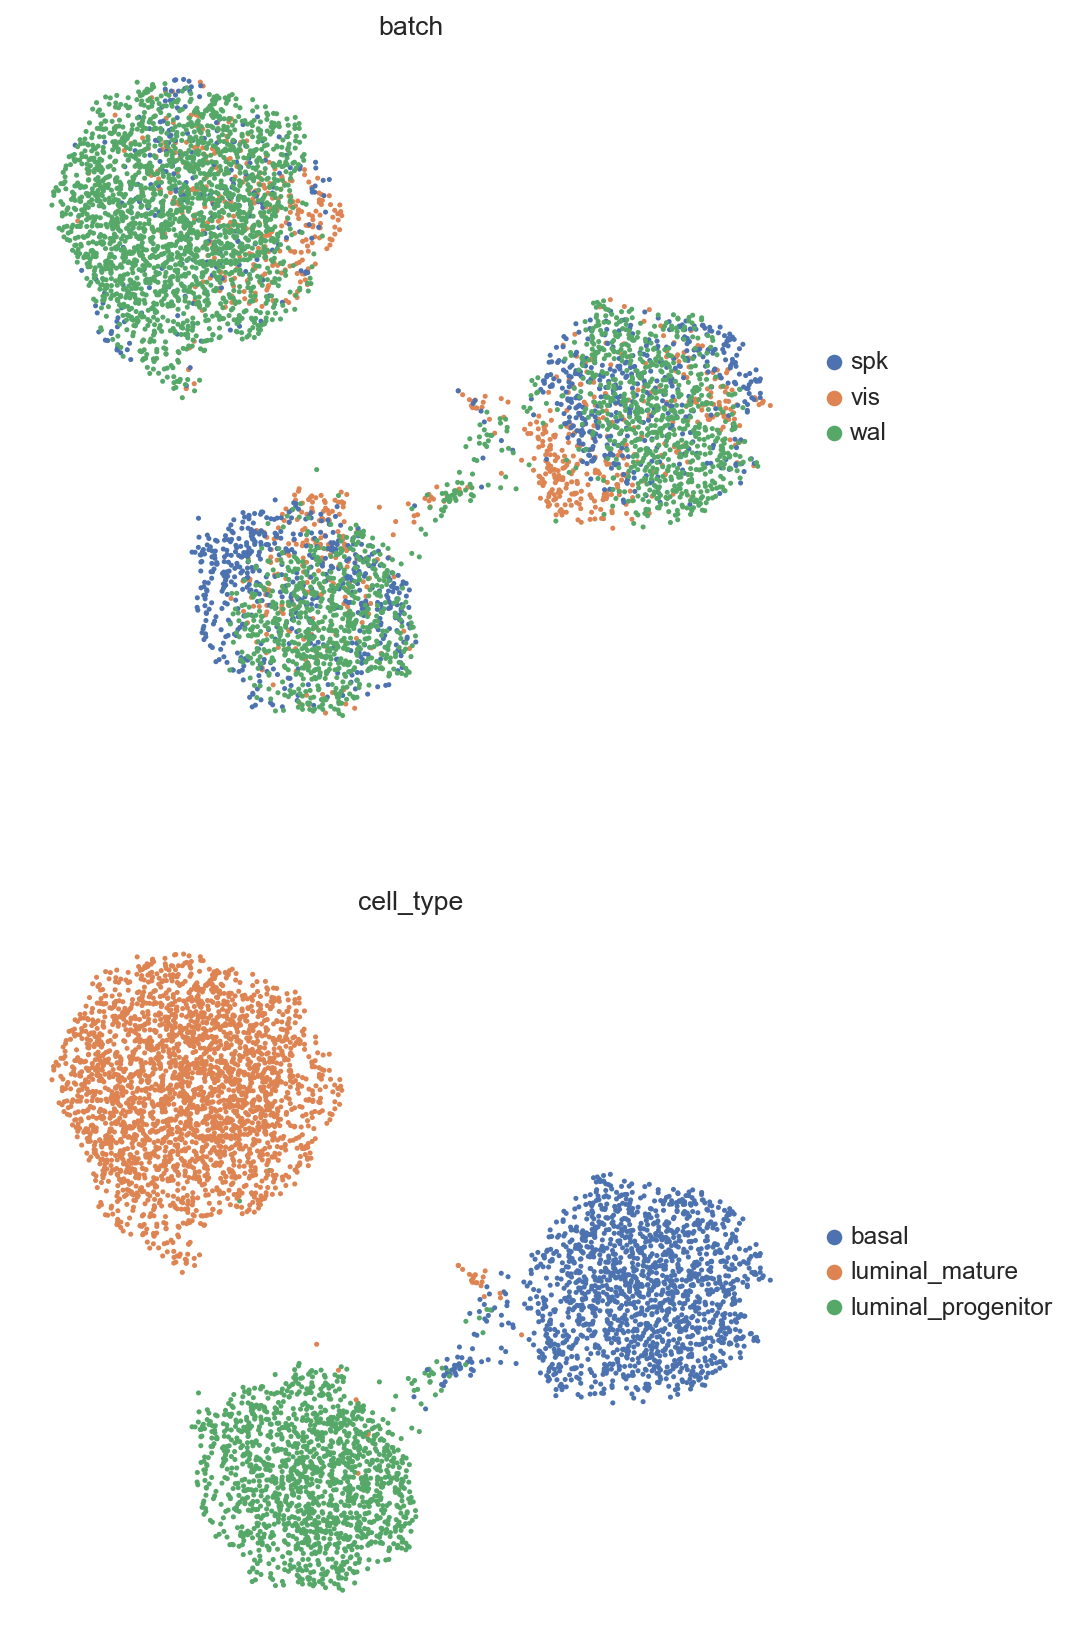

In [19]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [20]:
train = adata.copy()

### Preprocessing Data

In [21]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="cell_type")

## Creating and Training the model¶

In [22]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 28/100:  28%|▎| 28/100 [00:42<01:48,  1.51s/it, v_num=1, train_loss_step=4
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1765.852. Signaling Trainer to stop.


## Batch-Removal

In [23]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 5747 × 1222
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'study', 'cell.class', 'library_size', 'detected_genes', 'batch', 'cell_type', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [24]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [25]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

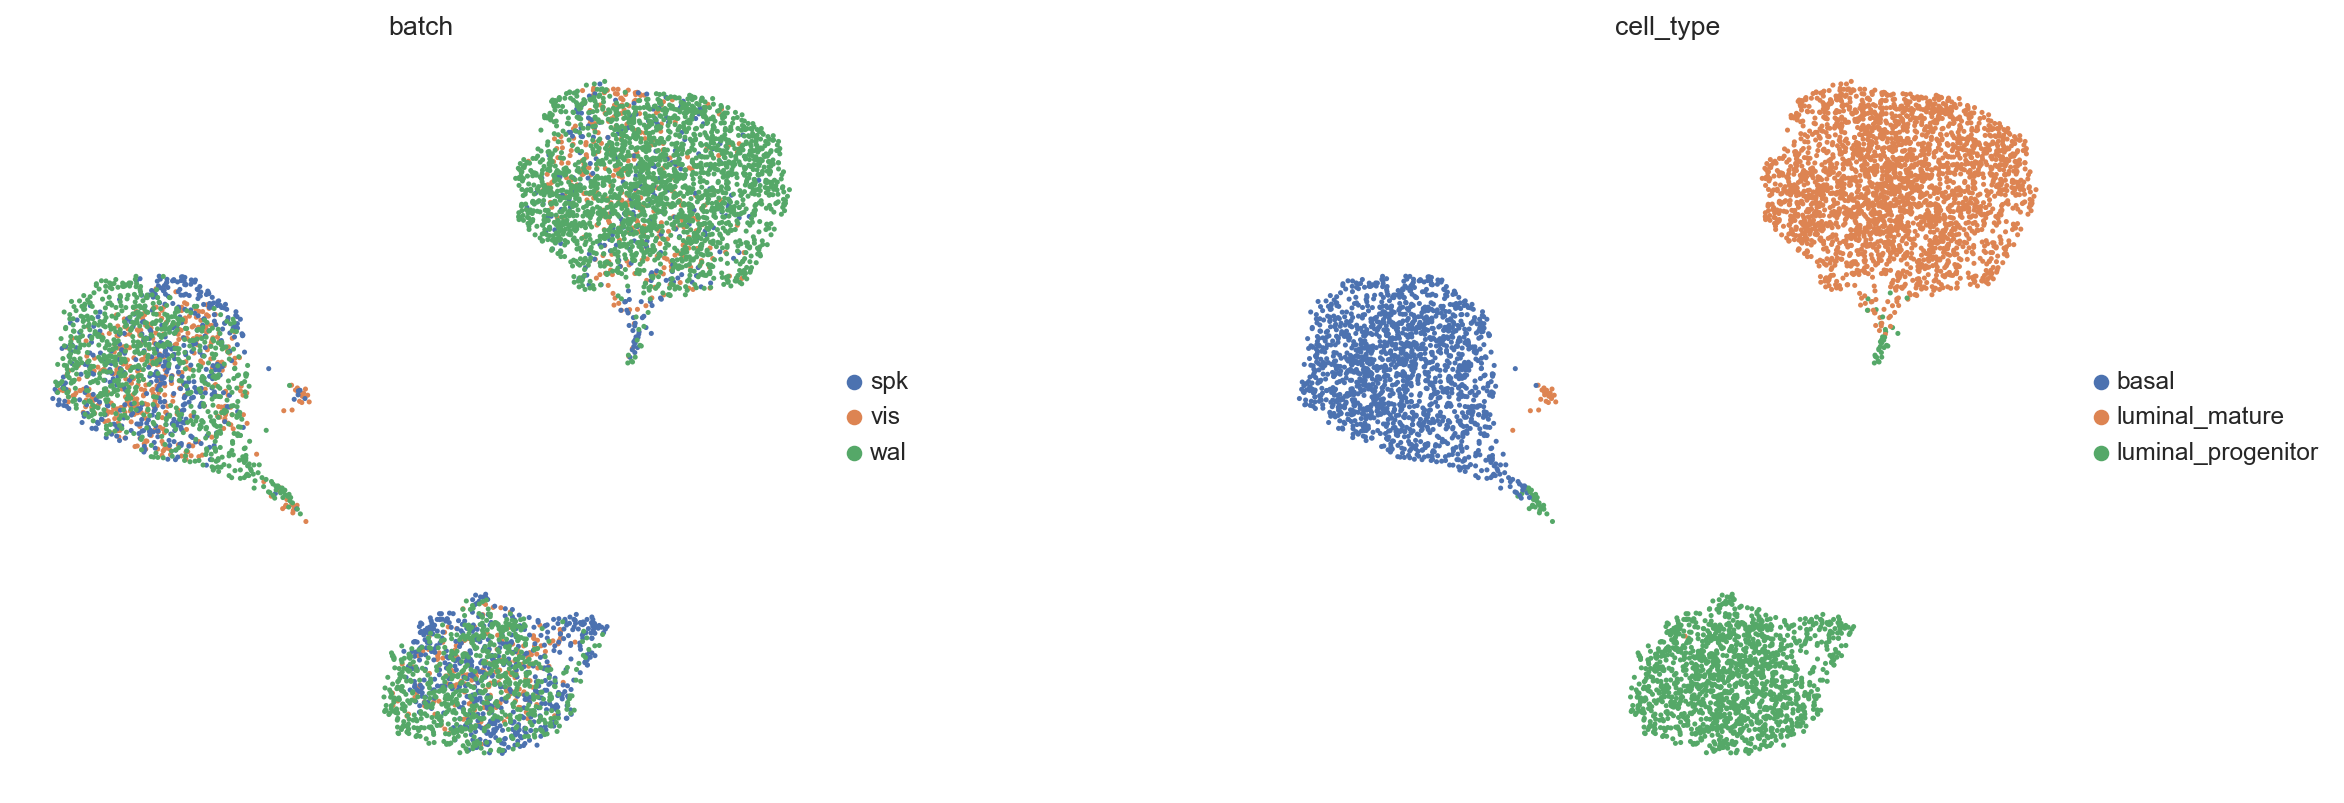

In [26]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [27]:
pca_embeddings = pd.read_csv('../R_bct/embeddings/bct_stacas_embeddings_full_labels.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [28]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

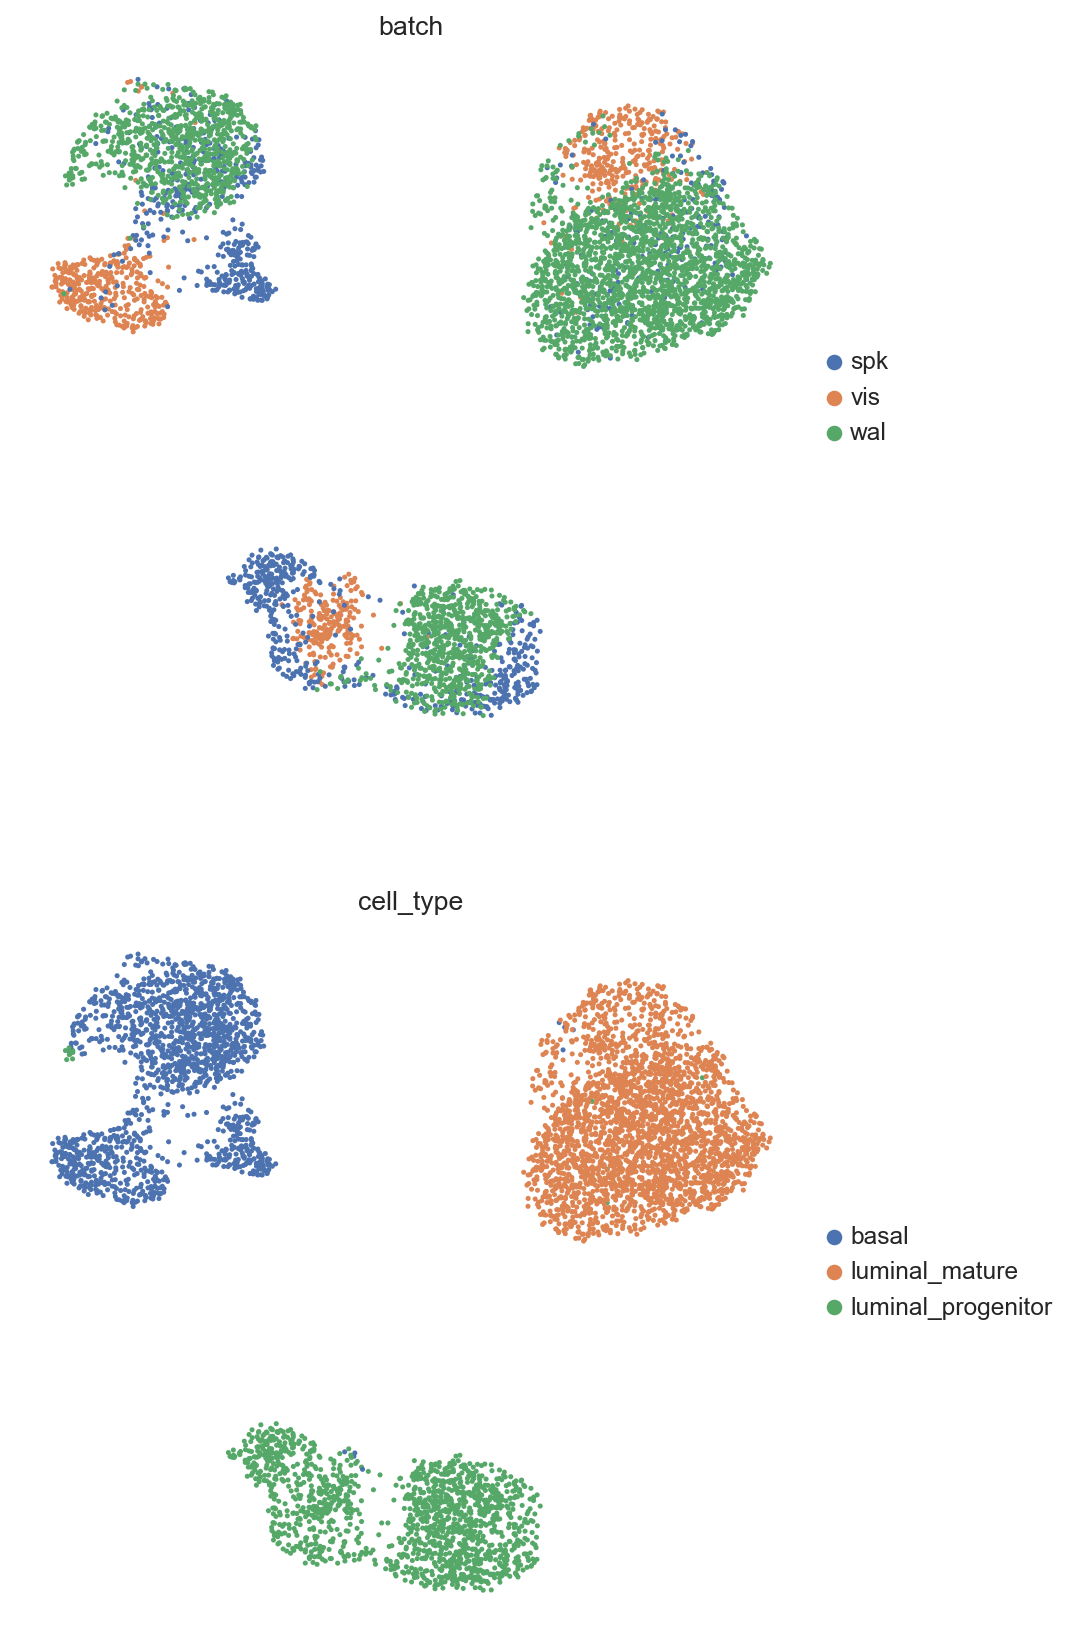

In [29]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [30]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_supervised_bct.csv")


# Metric Evaluation

## read the embeddings

In [31]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/full_annotated_supervised_bct.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [32]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.95170162625199
resolution: 0.2, nmi: 0.9391657747086226
resolution: 0.3, nmi: 0.9391657747086226
resolution: 0.4, nmi: 0.9423187035476
resolution: 0.5, nmi: 0.9284522918006111
resolution: 0.6, nmi: 0.92630699533138
resolution: 0.7, nmi: 0.891612114727193
resolution: 0.8, nmi: 0.8271590311026891
resolution: 0.9, nmi: 0.7367613870547164
resolution: 1.0, nmi: 0.6795299775876522
resolution: 1.1, nmi: 0.6514651345766918
resolution: 1.2, nmi: 0.5959000858845321
resolution: 1.3, nmi: 0.574865768638734
resolution: 1.4, nmi: 0.5502520804169363
resolution: 1.5, nmi: 0.5318829944563308
resolution: 1.6, nmi: 0.5294209157377592
resolution: 1.7, nmi: 0.5092097372600254
resolution: 1.8, nmi: 0.496844322188939
resolution: 1.9, nmi: 0.4890491964910386
resolution: 2.0, nmi: 0.48546677748812395
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.95170162625199
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scA

In [33]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.966225218005864
resolution: 0.2, nmi: 0.9570054357055681
resolution: 0.3, nmi: 0.9556064617327559
resolution: 0.4, nmi: 0.9497209233135394
resolution: 0.5, nmi: 0.9171151794842477
resolution: 0.6, nmi: 0.8032073649691285
resolution: 0.7, nmi: 0.7503474354554058
resolution: 0.8, nmi: 0.69986222331306
resolution: 0.9, nmi: 0.6310391915534145
resolution: 1.0, nmi: 0.6093462579733138
resolution: 1.1, nmi: 0.5849580854262194
resolution: 1.2, nmi: 0.5802614466178699
resolution: 1.3, nmi: 0.5778070664811936
resolution: 1.4, nmi: 0.5524127598100862
resolution: 1.5, nmi: 0.5448628067046083
resolution: 1.6, nmi: 0.5308732558053741
resolution: 1.7, nmi: 0.5133402137387489
resolution: 1.8, nmi: 0.5136659473859303
resolution: 1.9, nmi: 0.49942366421029716
resolution: 2.0, nmi: 0.48859319329126355
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.966225218005864
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on 

In [34]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.9759192270594332
resolution: 0.2, nmi: 0.8386755105776341
resolution: 0.3, nmi: 0.8184723587620619
resolution: 0.4, nmi: 0.7667130859165371
resolution: 0.5, nmi: 0.7651906614574041
resolution: 0.6, nmi: 0.7597265457584477
resolution: 0.7, nmi: 0.6967328904808447
resolution: 0.8, nmi: 0.6624833544297838
resolution: 0.9, nmi: 0.654936899242794
resolution: 1.0, nmi: 0.6539535075524869
resolution: 1.1, nmi: 0.6342893773205102
resolution: 1.2, nmi: 0.6311867511889157
resolution: 1.3, nmi: 0.6313264795627733
resolution: 1.4, nmi: 0.6027407205960508
resolution: 1.5, nmi: 0.6003614683140307
resolution: 1.6, nmi: 0.5704774294696244
resolution: 1.7, nmi: 0.5506042047174343
resolution: 1.8, nmi: 0.5493554422832698
resolution: 1.9, nmi: 0.5428094082844714
resolution: 2.0, nmi: 0.5407369256196778
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9759192270594332
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on

In [35]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/bct_metrics_supervised_full.csv", index=True)

In [36]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.959885,0.967745,0.973115
ARI_cluster/label,0.979132,0.984311,0.988283
ASW_label,0.592679,0.672742,0.687640
ASW_label/batch,0.957571,0.903942,0.877948
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.989801,0.993995,0.995706
isolated_label_silhouette,0.596444,0.666314,0.677556
graph_conn,1.000000,0.999776,1.000000
kBET,NaN,NaN,NaN
